### MobileNet

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


IndexError: list index out of range

In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [4]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

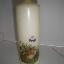

In [5]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/test_0.JPEG', width=300, height=200)

In [6]:
preprocessed_image = prepare_image('test_0.JPEG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 1s 981ms/step


[[('n03062245', 'cocktail_shaker', 0.44124803),
  ('n04522168', 'vase', 0.16893348),
  ('n03690938', 'lotion', 0.09498722),
  ('n04579145', 'whiskey_jug', 0.072693214),
  ('n04254120', 'soap_dispenser', 0.05771649)]]

In [7]:
assert results[0][0][1] == 'cocktail_shaker'

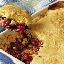

In [8]:
Image(filename='data/MobileNet-samples/test_1.JPEG', width=300, height=200)

In [9]:
preprocessed_image = prepare_image('test_1.JPEG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 64ms/step


[[('n07716906', 'spaghetti_squash', 0.27958873),
  ('n07684084', 'French_loaf', 0.085019),
  ('n01496331', 'electric_ray', 0.068929255),
  ('n02102973', 'Irish_water_spaniel', 0.05642391),
  ('n07871810', 'meat_loaf', 0.04284844)]]

In [10]:
assert results[0][0][1] == 'spaghetti_squash'

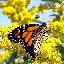

In [11]:
Image(filename='data/MobileNet-samples/test_2.JPEG', width=300, height=200)

In [12]:
preprocessed_image = prepare_image('test_2.JPEG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 58ms/step


[[('n01751748', 'sea_snake', 0.26426613),
  ('n02279972', 'monarch', 0.19796564),
  ('n01632458', 'spotted_salamander', 0.15183924),
  ('n02606052', 'rock_beauty', 0.100624405),
  ('n02276258', 'admiral', 0.054010507)]]

### Fine-tune MobileNet on sign language digits

#### Image Preperation

Dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset/tree/master/Dataset

- 10 classes (digits 0-9)
- Class data:
    - class 0: 205 images
    - class 1: 206 images
    - class 2: 206 images
    - class 3: 206 images
    - class 4: 207 images
    - class 5: 207 images
    - class 6: 207 images
    - class 7: 206 images
    - class 8: 208 images
    - class 9: 204 images
    
Dowmload data and save in current directory /data/Sign-Languages-Digits-Dataset. Extract sub-directories labeled 0 through 9 and nest directories directly underneath Sign-Language-Digits-Dataset directory. Directory structure should look like this:

- data/
    - Sign-Language-Digits-Dataset/
        - 0/
        - 1/
        - 2/
        - ...
        - 9/

In [13]:
# Organize data into train, valid, test dirs
os.chdir('C:/Users/Asus/data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [14]:
for i in range(0, 10):
    assert len(os.listdir(f'data/Sign-Language-Digits-Dataset/valid/{i}')) == 30
    assert len(os.listdir(f'data/Sign-Language-Digits-Dataset/test/{i}')) == 5

In [15]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

In [16]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [17]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

### Modify Model

In [18]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [19]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [20]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [21]:
params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

In [22]:
x = mobile.layers[-5].output
output = Dense(units=10, activation='softmax')(x)

In [23]:
model = Model(inputs=mobile.input, outputs=output)

In [24]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [25]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

x = mobile.layers[-5].output
x = GlobalAveragePooling2D()(x)  # 4D -> 2D tensor
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [27]:
params = count_params(model)
assert params['non_trainable_params'] == 1365184
assert params['trainable_params'] == 1873930

### Train the model

In [28]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Run for more epochs (~30) to see better results
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 113s - loss: 0.3316 - accuracy: 0.8896 - val_loss: 1.2849 - val_accuracy: 0.6767 - 113s/epoch - 657ms/step
Epoch 2/30
172/172 - 107s - loss: 0.1102 - accuracy: 0.9690 - val_loss: 1.1039 - val_accuracy: 0.7633 - 107s/epoch - 624ms/step
Epoch 3/30
172/172 - 107s - loss: 0.0521 - accuracy: 0.9831 - val_loss: 0.0883 - val_accuracy: 0.9700 - 107s/epoch - 622ms/step
Epoch 4/30
172/172 - 106s - loss: 0.0475 - accuracy: 0.9825 - val_loss: 0.0408 - val_accuracy: 0.9900 - 106s/epoch - 617ms/step
Epoch 5/30
172/172 - 106s - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0149 - val_accuracy: 0.9900 - 106s/epoch - 616ms/step
Epoch 6/30
172/172 - 106s - loss: 0.0380 - accuracy: 0.9866 - val_loss: 0.0792 - val_accuracy: 0.9567 - 106s/epoch - 616ms/step
Epoch 7/30
172/172 - 106s - loss: 0.0315 - accuracy: 0.9889 - val_loss: 0.1048 - val_accuracy: 0.9700 - 106s/epoch - 615ms/step
Epoch 8/30
172/172 - 106s - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0210 - val_accuracy: 0.9967 - 

### Predict sign language digits

In [30]:
test_labels = test_batches.classes

In [31]:
predictions = model.predict(x=test_batches, verbose=0)

In [32]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [33]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [35]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
  """
  This Function prints and plot the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("predicted label")

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 1 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


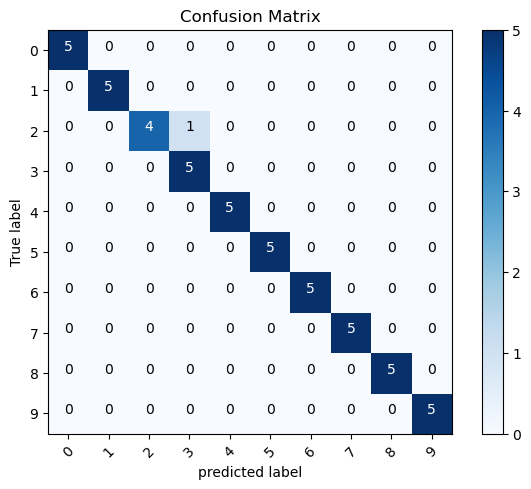

In [36]:
# Train model for more epochs to see better results
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Data Augmentation

- Flipping the image either horizontally and vertically
- Rotating the image 
- Zooming out in or out on the image
- Cropping the image
- Varying the color on the image

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [39]:
# This function will plot images in the form  of a grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [42]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
                        channel_shift_range=10., horizontal_flip=True)

In [43]:
chosen_image = random.choice(os.listdir('data/dogs-vs-cats/train/dog'))

In [44]:
image_path = 'data/dogs-vs-cats/train/dog/' + chosen_image

In [47]:
assert os.path.isfile(image_path)

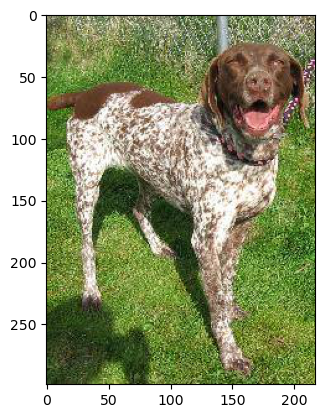

In [48]:
# Obtain image 
image = np.expand_dims(plt.imread(image_path), 0)
plt.imshow(image[0])

In [49]:
# Generate batches of augmented images from this image
aug_iter = gen.flow(image)

In [50]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint) for i in range(10)]

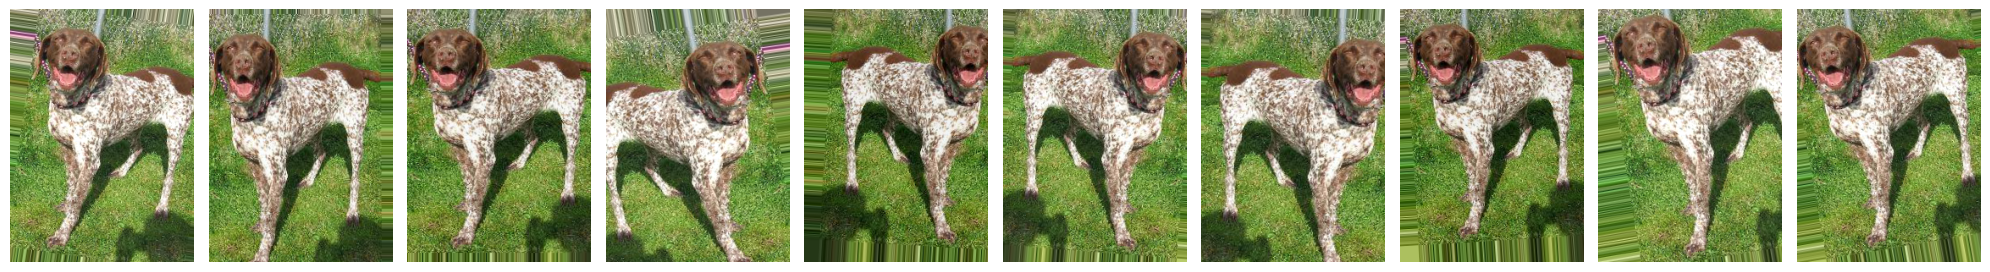

In [51]:
# Augmented images
plotImages(aug_images)